# K线图预测
## 依赖与超参数

In [1]:
from keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional, Multiply, BatchNormalization
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
SINGLE_ATTENTION_VECTOR = False
INPUT_DIMS = 4
TIME_STEPS = 20
lstm_units = 64
epoch = 30
dropout = 0.3

## 模型与使用到的函数

In [3]:
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    # a = Permute((2, 1))(inputs)
    # a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2), name='attention_vec')(a)

    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul


def create_dataset(dataset, look_back):
    """
    对数据进行处理
    """
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)

    return TrainX, Train_Y


# 多维归一化  返回数据和最大最小值
def NormalizeMult(data):
    # normalize 用于反归一化
    normalize = np.arange(2 * data.shape[1], dtype='float64')

    normalize = normalize.reshape(data.shape[1], 2)
    for i in range(0, data.shape[1]):
        #第i列
        list = data[:, i]
        listlow, listhigh = np.percentile(list, [0, 100])
        # print(i)
        normalize[i, 0] = listlow
        normalize[i, 1] = listhigh
        delta = listhigh - listlow
        if delta != 0:
            #第j行
            for j in range(0, data.shape[0]):
                data[j, i] = (data[j, i] - listlow) / delta
    return data, normalize


# 多维反归一化
def FNormalizeMult(data, normalize):
    data = np.array(data)
    for i in range(0, data.shape[1]):
        listlow = normalize[i, 0]
        listhigh = normalize[i, 1]
        delta = listhigh - listlow
        if delta != 0:
            #第j行
            for j in range(0, data.shape[0]):
                data[j, i] = data[j, i] * delta + listlow

    return data

def mean_squared_error(test_Y, pred_Y):
    # 将输入转换为 NumPy 数组以支持数组运算
    test_Y = np.array(test_Y)
    pred_Y = np.array(pred_Y)

    # 计算均方误差
    mse = np.mean((test_Y - pred_Y) ** 2)
    return mse



def attention_model():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))

    x = Conv1D(filters=64, kernel_size=1, activation='relu')(inputs)  
    x = Dropout(dropout)(x)

    # lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    # 对于GPU可以使用CuDNNLSTM
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    lstm_out = Dropout(dropout)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)

    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

def attention_model_with_norm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(inputs)
    x = BatchNormalization()(x)  # Added Batch Normalization
    x = Dropout(dropout)(x)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    lstm_out = BatchNormalization()(lstm_out)  # Added Batch Normalization
    lstm_out = Dropout(dropout)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

def lstm(model_type):
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    
    if model_type == 1:
        # single-layer LSTM
        x = LSTM(lstm_units, return_sequences=False)(inputs)
    
    if model_type == 2:
        # multi-layer LSTM
        x = LSTM(lstm_units, return_sequences=True)(inputs)
        x = LSTM(lstm_units, return_sequences=False)(x)
    
    if model_type == 3:
        # BiLSTM
        x = Bidirectional(LSTM(lstm_units, return_sequences=False))(inputs)
    
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[inputs], outputs=output)
    return model



In [4]:
# 加载数据
# data = pd.read_csv("./NFLX.csv")
data = pd.read_csv("./data.csv")
data = data[['open', 'close', 'high', 'low']]

# 归一化
data = np.array(data)
data, normalize = NormalizeMult(data)
close_column = data[:, 1].reshape(len(data), 1)



## 通过第t+1天开盘、最高、最低预测收盘

In [5]:
train_X, _ = create_dataset(data, TIME_STEPS)
_, train_Y = create_dataset(close_column, TIME_STEPS)

train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=42)

print(train_X.shape, train_Y.shape)

(21004, 20, 4) (21004, 1)


In [6]:
# m = attention_model()
model_type = 1
m = lstm(model_type)


m.summary()
m.compile(optimizer='adam', loss='mse')
history = m.fit([train_X], train_Y, epochs=epoch, batch_size=64, validation_split=0.1)
# m.save("./model.h5")
# np.save("normalize.npy", normalize)

# 使用测试集进行预测
pred_Y = m.predict(test_X)

# After predictions
pred_Y_denormalized = FNormalizeMult(pred_Y, normalize)

# Assuming test_Y needs denormalization as well
test_Y_denormalized = FNormalizeMult(test_Y, normalize)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 4)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                17664     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 17,985
Trainable params: 17,857
Non-trainable params: 128
_________________________________________________________________

Train on 18903 samples, validate on 2

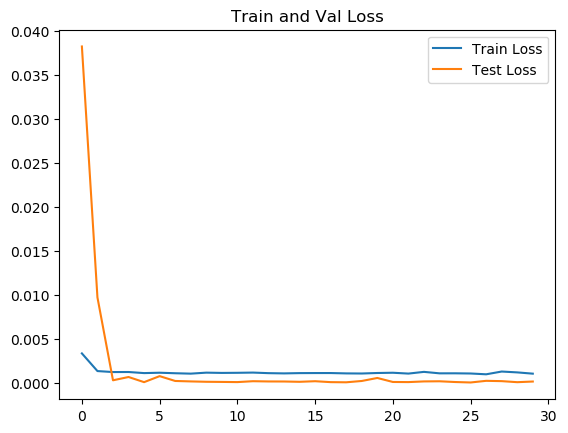

In [7]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epoch)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

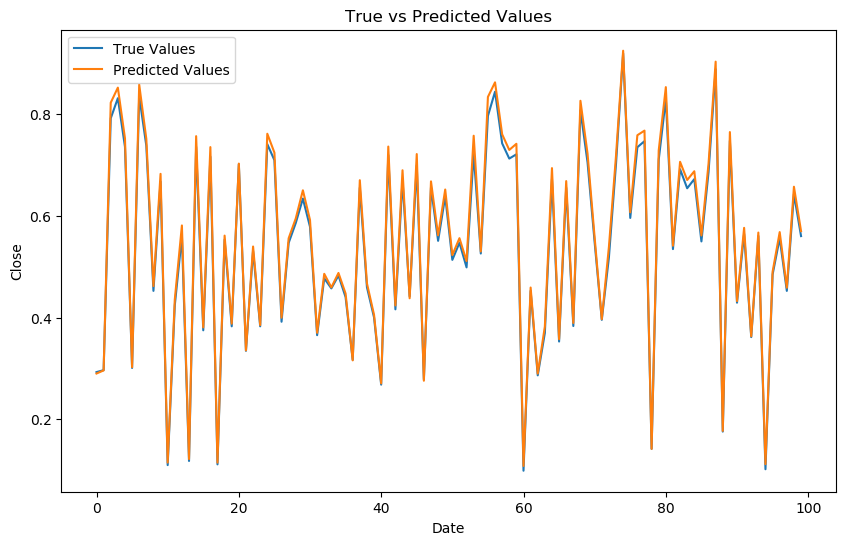

In [8]:
# 绘制预测值和真实值
plt.figure(figsize=(10, 6))
plt.plot(test_Y[:100], label='True Values')
plt.plot(pred_Y[:100], label='Predicted Values')
plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

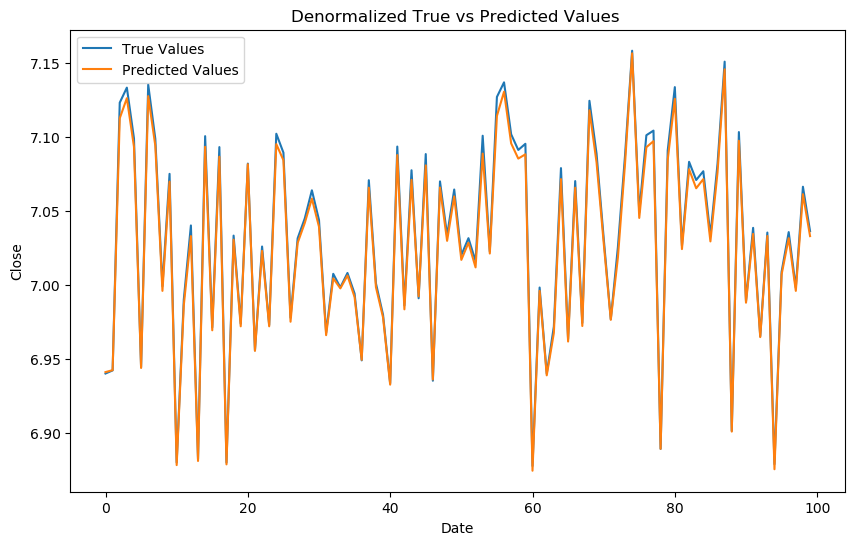

In [9]:
# 绘制预测值和真实值
plt.figure(figsize=(10, 6))
plt.plot(pred_Y_denormalized[:100], label='True Values')
plt.plot(test_Y_denormalized[:100], label='Predicted Values')
plt.title('Denormalized True vs Predicted Values ')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

In [10]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def up_down_accuracy(y_true, y_pred):
    y_var_test=y_true[1:]-y_true[:len(y_true)-1]#实际涨跌
    y_var_predict=y_pred[1:]-y_pred[:len(y_pred)-1]#原始涨跌
    txt=np.zeros(len(y_var_test))
    for i in range(len(y_var_test-1)):#计算数量
        txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
    result=sum(txt)/len(txt)
    return result

print('测试集上的MAE/MSE/MAPE/涨跌准确率')
print(mean_absolute_error(pred_Y, test_Y))
print(mean_squared_error(pred_Y, test_Y) )
print(mape(pred_Y, test_Y) )
print(up_down_accuracy(pred_Y, test_Y))

测试集上的MAE/MSE/MAPE/涨跌准确率
0.011220601645673072
0.00018059014927227616
2.4698131111247608
0.9918110836031232


## 通过前t天预测T+1天开盘、收盘、高点、低点

In [11]:
def create_dataset_tomorrow(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)
    return TrainX, Train_Y

In [12]:
train_X, train_Y = create_dataset_tomorrow(data, TIME_STEPS)
train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=42)

print(train_X.shape, train_Y.shape)

(21005, 20, 4) (21005, 4)


In [13]:
def attention_model2():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(inputs)
    x = Dropout(dropout)(x)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    lstm_out = Dropout(dropout)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(4, activation='linear')(attention_mul)  # 修改了输出
    model = Model(inputs=[inputs], outputs=output)
    return model

In [14]:
m = attention_model2()

m.summary()
m.compile(optimizer='adam', loss='mse')
history = m.fit([train_X], train_Y, epochs=epoch, batch_size=64, validation_split=0.1)
# m.save("./model.h5")
# np.save("normalize.npy", normalize)

# 使用测试集进行预测
pred_Y = m.predict(test_X)

# After predictions
pred_Y_denormalized = FNormalizeMult(pred_Y, normalize)

# Assuming test_Y needs denormalization as well
test_Y_denormalized = FNormalizeMult(test_Y, normalize)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20, 4)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 20, 64)       320         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 20, 64)       0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 20, 128)      66048       dropout_2[0][0]                  
____________________________________________________________________________________________

KeyboardInterrupt: 

In [ ]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epoch)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

In [ ]:
# 绘制预测值和真实值
plt.figure(figsize=(10, 6))
plt.plot(test_Y[:100, 1], label='True Values')
plt.plot(pred_Y[:100, 1], label='Predicted Values')
plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
# 绘制预测值和真实值
plt.figure(figsize=(10, 6))
plt.plot(test_Y_denormalized[:100, 1], label='True Values')
plt.plot(pred_Y_denormalized[:100, 1], label='Predicted Values')
plt.title('Denormalized True vs Predicted Values ')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
def calculate_metrics(test_Y, pred_Y):
    # MAE
    mae = mean_absolute_error(test_Y, pred_Y)
    
    # MSE
    mse = mean_squared_error(test_Y, pred_Y)
    
    # # MAPE
    # mape = np.mean(np.abs((test_Y - pred_Y) / test_Y)) * 100
    
    # 涨跌准确率
    test_diff = np.diff(test_Y[:, 1])  # 计算真实值的涨跌
    pred_diff = np.diff(pred_Y[:, 1])  # 计算预测值的涨跌
    test_sign = np.sign(test_diff)  # 获取真实值涨跌的符号
    pred_sign = np.sign(pred_diff)  # 获取预测值涨跌的符号
    accuracy = np.mean(test_sign == pred_sign) * 100  # 计算涨跌准确率
    
    return mae, mse, accuracy

# 使用示例
mae, mse, accuracy = calculate_metrics(test_Y, pred_Y)
print(f"MAE: {mae}")
print(f"MSE: {mse}")
# print(f"MAPE: {mape}%")
print(f"涨跌准确率: {accuracy}%")

## 应用:CSGO饰品价格预测

In [ ]:
import pandas as pd
name = "CSOB_AK-47 _ 怪兽在B (久经沙场)_悠悠有品_K线图 (1)"

# 读取 Excel 文件
excel_file = f'./{name}.xlsx'
df = pd.read_excel(excel_file, header=3, engine='openpyxl')

# 去掉前3行
df = df.iloc[3:]
df = df.drop(df.columns[[0, 5]], axis=1)

# 修改标题
df.columns = ['open', 'close', 'high', 'low']

# 保存为 CSV 文件
csv_file = f'./{name}.csv'
df.to_csv(csv_file, index=False)

In [ ]:
def create_dataset_7days(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 7):  # 预测7天后的数据
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back + 6, :])  # 目标是7天后的数据
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)
    return TrainX, Train_Y

In [ ]:
data = pd.read_csv(f"./{name}.csv")
yesterday_prices = data.iloc[-1]
data = np.array(data)
data, normalize = NormalizeMult(data)
# Prepare data
train_X, train_Y = create_dataset_7days(data, TIME_STEPS)

# 使用时注释掉
# train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=42)

In [ ]:
mm = attention_model2()


mm.summary()
mm.compile(optimizer='adam', loss='mse')
mm.fit([train_X], train_Y, epochs=epoch, batch_size=64, validation_split=0.1)


In [ ]:
today_data = data[-TIME_STEPS:].reshape(1, TIME_STEPS, INPUT_DIMS)
# 使用
pred_today = mm.predict(today_data)
# 测试
# pred_today = mm.predict(test_X)

pred_Y_denormalized = FNormalizeMult(pred_today, normalize)

print("Yesterday's Prices:")
print(yesterday_prices)
print("\nToday's Prices:")
print('open', 'close', 'high', 'low')
print(pred_Y_denormalized)

In [ ]:
# test_Y_denormalized = FNormalizeMult(test_Y, normalize)
# plt.figure(figsize=(10, 6))
# plt.plot(test_Y_denormalized[:100, 1], label='True Values')
# plt.plot(pred_Y_denormalized[:100, 1], label='Predicted Values')
# plt.title('Denormalized True vs Predicted Values ')
# plt.xlabel('Date')
# plt.ylabel('Close')
# plt.legend()
# plt.show()